Занятие 6. Линейная регрессия
======================
Упражнение 1
===========

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
#   Для разнообразия
matplotlib.style.use('seaborn')
%matplotlib inline

In [2]:
from sklearn.linear_model import LinearRegression

In [3]:
import os

os.chdir("C:/Users/USER/Documents/Python/_AD_Python_part_1_Lectures/AD_Python_1_05_regression_forecast")


### Прогнозирование временных рядов.

In [4]:
df = pd.read_csv('fancy.csv', decimal = ",", sep=';')
df.head()

,sales
0,1664.81
1,2397.53
2,2840.71
3,3547.29
4,3752.96


Построим график продаж. <br> 
Надо разгадать тип тренда (линейный или нет) и характер сезонности (аддитивный или мультипликативный). <br>  
На первом графике для исходного ряда видны линейный тренд и мультипликативная сезонность. <br>
На втором графике ряд логарифмов исходного ряда. На нем сезонные поправки стали аддитивными, это подтверждает гипотезу о мультипликативном характере сезонности.

Text(0, 0.5, 'log10 от тысяч долларов')

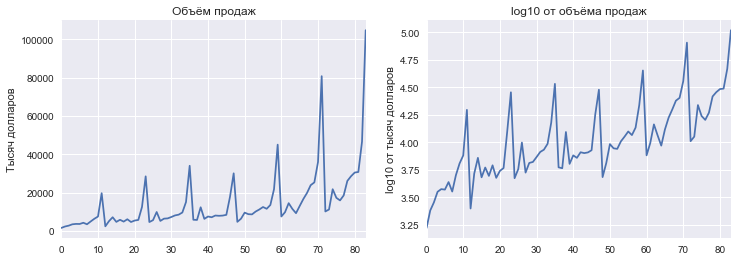

In [5]:
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(121)
df['sales'].plot(ax=ax1)
ax1.set_title(u'Объём продаж')
ax1.set_ylabel(u'Тысяч долларов')

ax2 = fig.add_subplot(122)
pd.Series(np.log10(df['sales'])).plot(ax=ax2)
ax2.set_title(u'log10 от объёма продаж')
ax2.set_ylabel(u'log10 от тысяч долларов')


Вывод: будем прогнозировать логарифм продаж с помощью модели линейной регрессии. 
$$\log y_i = \alpha + \beta \cdot x_i + c(x_i) + \varepsilon_i,$$
где $y_i$ -- объём продаж, $x_i$ -- порядковый номер месяца, $c(x_i)$ -- сезонная составляющая, $\varepsilon_i$ -- случайные отклонения.

Прологарифмируем временной ряд.

In [6]:
df_0 = pd.DataFrame(np.log10(df['sales']))

In [7]:
print(df_0)

       sales
0   3.221365
1   3.379764
2   3.453427
3   3.549897
4   3.574374
..       ...
79  4.456161
80  4.484377
81  4.488851
82  4.668706
83  5.019784

[84 rows x 1 columns]


Создадим регрессионную переменную ```month_num``` -- порядковый номер пары (месяц, год). Тем самым мы зададим линейный тренд

In [8]:
df_0['month_num'] = range(1, len(df_0) + 1)


#  Все хорошо?
df_0.head()

,sales,month_num
0,3.221365,1
1,3.379764,2
2,3.453427,3
3,3.549897,4
4,3.574374,5


Создадим новые переменные - индикаторы месяцев <br>
Внимание: создаем строки за запасом, а затем отрезаем лишние

In [9]:
#  Индикаторы месяцев


df_0["m01"] = ([1,0,0,0,0,0,0,0,0,0,0,0]*7)[0:len(df_0)]
df_0["m02"] = ([0,1,0,0,0,0,0,0,0,0,0,0]*7)[0:len(df_0)]
df_0["m03"] = ([0,0,1,0,0,0,0,0,0,0,0,0]*7)[0:len(df_0)]
df_0["m04"] = ([0,0,0,1,0,0,0,0,0,0,0,0]*7)[0:len(df_0)]
df_0["m05"] = ([0,0,0,0,1,0,0,0,0,0,0,0]*7)[0:len(df_0)]
df_0["m06"] = ([0,0,0,0,0,1,0,0,0,0,0,0]*7)[0:len(df_0)]
df_0["m07"] = ([0,0,0,0,0,0,1,0,0,0,0,0]*7)[0:len(df_0)]
df_0["m08"] = ([0,0,0,0,0,0,0,1,0,0,0,0]*7)[0:len(df_0)]
df_0["m09"] = ([0,0,0,0,0,0,0,0,1,0,0,0]*7)[0:len(df_0)]
df_0["m10"] = ([0,0,0,0,0,0,0,0,0,1,0,0]*7)[0:len(df_0)]
df_0["m11"] = ([0,0,0,0,0,0,0,0,0,0,1,0]*7)[0:len(df_0)]
df_0["m12"] = ([0,0,0,0,0,0,0,0,0,0,0,1]*7)[0:len(df_0)]


In [10]:
#  Все хорошо?

df_0.head(14)

,sales,month_num,m01,m02,m03,m04,m05,m06,m07,m08,m09,m10,m11,m12
0,3.221365,1,1,0,0,0,0,0,0,0,0,0,0,0
1,3.379764,2,0,1,0,0,0,0,0,0,0,0,0,0
2,3.453427,3,0,0,1,0,0,0,0,0,0,0,0,0
3,3.549897,4,0,0,0,1,0,0,0,0,0,0,0,0
4,3.574374,5,0,0,0,0,1,0,0,0,0,0,0,0
5,3.569928,6,0,0,0,0,0,1,0,0,0,0,0,0
6,3.638450,7,0,0,0,0,0,0,1,0,0,0,0,0
7,3.552223,8,0,0,0,0,0,0,0,1,0,0,0,0
8,3.700861,9,0,0,0,0,0,0,0,0,1,0,0,0
9,3.807770,10,0,0,0,0,0,0,0,0,0,1,0,0


In [11]:
#  Создаем матрицу предикторов.
#  Убираем из нее отклик и столбец индикаторов базового месяца
#  За базу берем январь, почему-то январь - месяц минимальных продаж
#  Все же середина лета
X = df_0.drop(columns=["sales", "m01"])

In [12]:
#  Создаем матрицу (столбец) откликов.
y = df_0['sales']

In [13]:
model = LinearRegression()
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [14]:
coef = pd.DataFrame(list(zip(['intercept'] + X.columns.tolist(), [model.intercept_] + model.coef_.tolist())),
                    columns=['predictor', 'coef'])
coef

,predictor,coef
0,intercept,3.303183
1,month_num,0.009725
2,m02,0.109027
3,m03,0.301924
4,m04,0.166306
5,m05,0.177190
6,m06,0.194113
7,m07,0.264145
8,m08,0.254215
9,m09,0.289390


In [15]:
from scipy import stats

def regression_coef(model, X, y):
    coef = pd.DataFrame(list(zip(['intercept'] + X.columns.tolist(), [model.intercept_] + model.coef_.tolist())),
                    columns=['predictor', 'coef'])
    X1 = np.append(np.ones((len(X),1)), X, axis=1)
    b = np.append(model.intercept_, model.coef_)
    MSE = np.sum((model.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
    var_b = MSE * (np.linalg.inv(np.dot(X1.T, X1)).diagonal())
    sd_b = np.sqrt(var_b)
    t = b / sd_b
    coef['pvalue'] = [2 * (1 - stats.t.cdf(np.abs(i), (len(X1) - 1))) for i in t]
    return coef

In [16]:
regression_coef(model, X, y)

,predictor,coef,pvalue
0,intercept,3.303183,0.000000e+00
1,month_num,0.009725,0.000000e+00
2,m02,0.109027,1.277308e-02
3,m03,0.301924,4.936103e-10
4,m04,0.166306,2.076656e-04
5,m05,0.177190,8.475913e-05
6,m06,0.194113,1.976859e-05
7,m07,0.264145,2.508040e-08
8,m08,0.254215,6.873020e-08
9,m09,0.289390,1.948717e-09


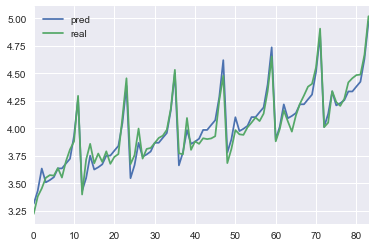

In [17]:
#  Сравним подгонку и ряд из логарифмов продаж

pred = pd.DataFrame({
    'pred': model.predict(X),
    'real': y})
pred.plot()

In [18]:
pred.head(14)

,pred,real
0,3.312908,3.221365
1,3.431660,3.379764
2,3.634283,3.453427
3,3.508390,3.549897
4,3.528999,3.574374
5,3.555647,3.569928
6,3.635404,3.638450
7,3.635200,3.552223
8,3.680099,3.700861
9,3.723564,3.807770


Только что построили подгонку (fit), используя модель для временного ряда. <br>
Переходим к прогнозированию.

In [26]:
print("Исторические данные за ", len(df), " месяцев")
print("Это составляет ", len(df)//12, " полных лет")
print("И еще ", len(df) % 12, " месяцев.")

Исторические данные за  84  месяцев
Это составляет  7  полных лет
И еще  0  месяцев.


Вопрос <br>
Что пришлось бы менять, если бы остаток от деления равнялся 5 месяцам?

In [19]:
#  Готовим матрицу значений предикторов df_3 
#  для вычисления прогнозов на 8 месяцев вперед
#  Сначала добавляем в нее время (номер месяца)

df_3= pd.DataFrame()

df_3['month_num'] = range(len(df_0)+1, len(df_0)+9)


In [20]:
df_3

,month_num
0,85
1,86
2,87
3,88
4,89
5,90
6,91
7,92


In [21]:
#  Добавляем индикаторы месяцев. Базового месяца снова не должно быть
# df_3["m01"] = ([1,0,0,0,0,0,0,0,0,0,0,0])[0: 8 ]
df_3["m02"] = ([0,1,0,0,0,0,0,0,0,0,0,0])[0: 8 ]
df_3["m03"] = ([0,0,1,0,0,0,0,0,0,0,0,0])[0: 8 ]
df_3["m04"] = ([0,0,0,1,0,0,0,0,0,0,0,0])[0: 8 ]
df_3["m05"] = ([0,0,0,0,1,0,0,0,0,0,0,0])[0: 8 ]
df_3["m06"] = ([0,0,0,0,0,1,0,0,0,0,0,0])[0: 8 ]
df_3["m07"] = ([0,0,0,0,0,0,1,0,0,0,0,0])[0: 8 ]
df_3["m08"] = ([0,0,0,0,0,0,0,1,0,0,0,0])[0: 8 ]
df_3["m09"] = ([0,0,0,0,0,0,0,0,1,0,0,0])[0: 8 ]
df_3["m10"] = ([0,0,0,0,0,0,0,0,0,1,0,0])[0: 8 ]
df_3["m11"] = ([0,0,0,0,0,0,0,0,0,0,1,0])[0: 8 ]
df_3["m12"] = ([0,0,0,0,0,0,0,0,0,0,0,1])[0: 8 ]


In [22]:
df_3

,month_num,m02,m03,m04,m05,m06,m07,m08,m09,m10,m11,m12
0,85,0,0,0,0,0,0,0,0,0,0,0
1,86,1,0,0,0,0,0,0,0,0,0,0
2,87,0,1,0,0,0,0,0,0,0,0,0
3,88,0,0,1,0,0,0,0,0,0,0,0
4,89,0,0,0,1,0,0,0,0,0,0,0
5,90,0,0,0,0,1,0,0,0,0,0,0
6,91,0,0,0,0,0,1,0,0,0,0,0
7,92,0,0,0,0,0,0,1,0,0,0,0


In [23]:
#  Прогноз для логарфмов
model.predict(df_3)


array([4.12982074, 4.24857277, 4.45119542, 4.32530233, 4.34591104,
       4.37255984, 4.45231632, 4.45211208])

In [24]:
#  Прогноз для исходного ряда
y1 = 10**model.predict(df_3)

In [25]:
y1

array([13484.06210902, 17724.45024824, 28261.51383389, 21149.60853585,
       22177.4208089 , 23580.87095379, 28334.54982535, 28321.22817136])

In [27]:
#  матрица с подгонкой
pred['forecast'] = np.nan

#  Все хорошо?
pred.head()

,pred,real,forecast
0,3.312908,3.221365,NaN
1,3.431660,3.379764,NaN
2,3.634283,3.453427,NaN
3,3.508390,3.549897,NaN
4,3.528999,3.574374,NaN


In [28]:
#  Продолжение предыдущей матрицы. 
#  Оно содержит спрогнозированные значения для месяцев с 85-го по 92-ый.
#  Для этих месяцев есть спрогнозированные значения, 
#  но нет исторических и подгонки.

#  Порядок столбцов не важен. 
#  Имена столбцов должны быть как в матрице pred ранее

pred_2 = pd.DataFrame(model.predict(df_3), columns=['forecast'])
pred_2['real'] = np.nan
pred_2['pred'] = np.nan

pred_2.head()

,forecast,real,pred
0,4.129821,NaN,NaN
1,4.248573,NaN,NaN
2,4.451195,NaN,NaN
3,4.325302,NaN,NaN
4,4.345911,NaN,NaN


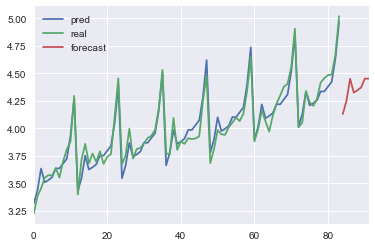

In [29]:
#  объединяем матрицы, задаем новые индексы
pred_3 = pd.concat(
    [pred, pred_2],
    sort=False
).reset_index(drop=True)

pred_3.plot()

In [30]:
#  Возвращаемся к исходному ряду
pred_4 = 10**pred_3

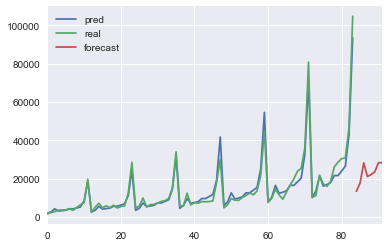

In [31]:
pred_4.plot()